<a href="https://colab.research.google.com/github/hermathena/Predicting-Energy-Consumption/blob/main/Predicting_Energy_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install catboost
!pip install shap
!pip install skimpy

In [79]:
# Data manipulation
#===========================================================================
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Data visualization
#===========================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

# Stats
#===========================================================================
from scipy import stats
#import pingouin as pg
import statsmodels.api as sm
#import ppscore as pps
from scipy.stats import shapiro

# Preprocessing
#===========================================================================
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifier Models
#===========================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Regression Models
#===========================================================================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# GridSearchCV
#===========================================================================
from sklearn.model_selection import GridSearchCV

# Metrics
#===========================================================================
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Feature importance
#===========================================================================
import shap

# tqdm
#===========================================================================
from tqdm.auto import tqdm

# Warnings
#===========================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Energy_consumption.csv to Energy_consumption.csv


In [13]:
data = pd.read_csv("Energy_consumption.csv")

In [14]:
data.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [15]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1000   │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 11     │ │ float64     │ 5     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA  ┃ NA %   ┃ mean   ┃ sd   ┃ p0       ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ Temperature            │   0 │      0 │     25 │  2.8 │       20 │    23 │    25 │    27 │    30 │ ▆▇▇▇▆▇  │  │
│ │ Humidity               │   0 │      0 │     45 │  8.5 │       30 │    38 │    46 │    52 │    60 │ ▆▆▇▇▇▇  │  │
│ │ SquareFootage          │   0 │      0 │   1500 │  290 │     1000 │  1200 │  1500 │  1700 │  2000 │ ▇▇▇▇▇▇  │  │
│ │ Occupancy              │   0 │      0 │    4.6 │  2.9 │        0 │     2 │     5 │     7 │     9 │ ▇▃▇▃▇▇  │  │
│ │ RenewableEnergy        │   0 │      0 │     15 │  8.7 │   0.0066 │   7.6 │    15 │    23 │    30 │ ▇▇▇▇▇▇  │  │
│ │ EnergyConsumption      │   0 │      0 │     77 │  8.1 │       53 │    72 │    77 │    83 │    99 │ ▁▃▇▇▅▁  │  │
│ └────────────────────────┴─────┴────────┴────────┴──────┴──────────┴───────┴───────┴───────┴───────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Timestamp                    │      0 │          0 │                           2 │                    2000 │  │
│ │ HVACUsage                    │      0 │          0 │                           1 │                    1000 │  │
│ │ LightingUsage                │      0 │          0 │                           1 │                    1000 │  │
│ │ DayOfWeek                    │      0 │          0 │                           1 │                    1000 │  │
│ │ Holiday                      │      0 │          0 │                           1 │                    1000 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [16]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month

In [17]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1000   │ │ float64     │ 5     │                                                          │
│ │ Number of columns │ 13     │ │ string      │ 4     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 3     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name           ┃ NA  ┃ NA %   ┃ mean   ┃ sd     ┃ p0       ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ Temperature           │   0 │      0 │     25 │    2.8 │       20 │    23 │    25 │    27 │    30 │ ▆▇▇▇▆▇ │  │
│ │ Humidity              │   0 │      0 │     45 │    8.5 │       30 │    38 │    46 │    52 │    60 │ ▆▆▇▇▇▇ │  │
│ │ SquareFootage         │   0 │      0 │   1500 │    290 │     1000 │  1200 │  1500 │  1700 │  2000 │ ▇▇▇▇▇▇ │  │
│ │ Occupancy             │   0 │      0 │    4.6 │    2.9 │        0 │     2 │     5 │     7 │     9 │ ▇▃▇▃▇▇ │  │
│ │ RenewableEnergy       │   0 │      0 │     15 │    8.7 │   0.0066 │   7.6 │    15 │    23 │    30 │ ▇▇▇▇▇▇ │  │
│ │ EnergyConsumption     │   0 │      0 │     77 │    8.1 │       53 │    72 │    77 │    83 │    99 │ ▁▃▇▇▅▁ │  │
│ │ Day                   │   0 │      0 │     13 │      9 │        1 │     6 │    11 │    21 │    31 │ ▇▇▅▃▃▅ │  │
│ │ Month                 │   0 │      0 │    1.3 │   0.44 │        1 │     1 │     1 │     2 │     2 │ ▇    ▃ │  │
│ └───────────────────────┴─────┴────────┴────────┴────────┴──────────┴───────┴───────┴───────┴───────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA    ┃ NA %     ┃ first            ┃ last                           ┃ frequency      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩  │
│ │ Timestamp          │     0 │        0 │    2022-01-01    │      2022-02-11 15:00:00       │ h              │  │
│ └────────────────────┴───────┴──────────┴──────────────────┴────────────────────────────────┴────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ HVACUsage                    │      0 │          0 │                           1 │                    1000 │  │
│ │ LightingUsage                │      0 │          0 │

In [18]:
columns_to_encode = ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']


data = pd.get_dummies(data, columns=columns_to_encode)

In [19]:
data.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption,Day,Month,HVACUsage_Off,HVACUsage_On,LightingUsage_Off,LightingUsage_On,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Holiday_No,Holiday_Yes
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,2.774699,75.364373,1,1,False,True,True,False,False,True,False,False,False,False,False,True,False
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,21.831384,83.401855,1,1,False,True,False,True,False,False,True,False,False,False,False,True,False
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,6.764672,78.270888,1,1,True,False,True,False,False,False,False,True,False,False,False,True,False
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,8.623447,56.519850,1,1,True,False,False,True,False,False,False,False,False,False,True,True,False
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,3.071969,70.811732,1,1,False,True,True,False,True,False,False,False,False,False,False,True,False


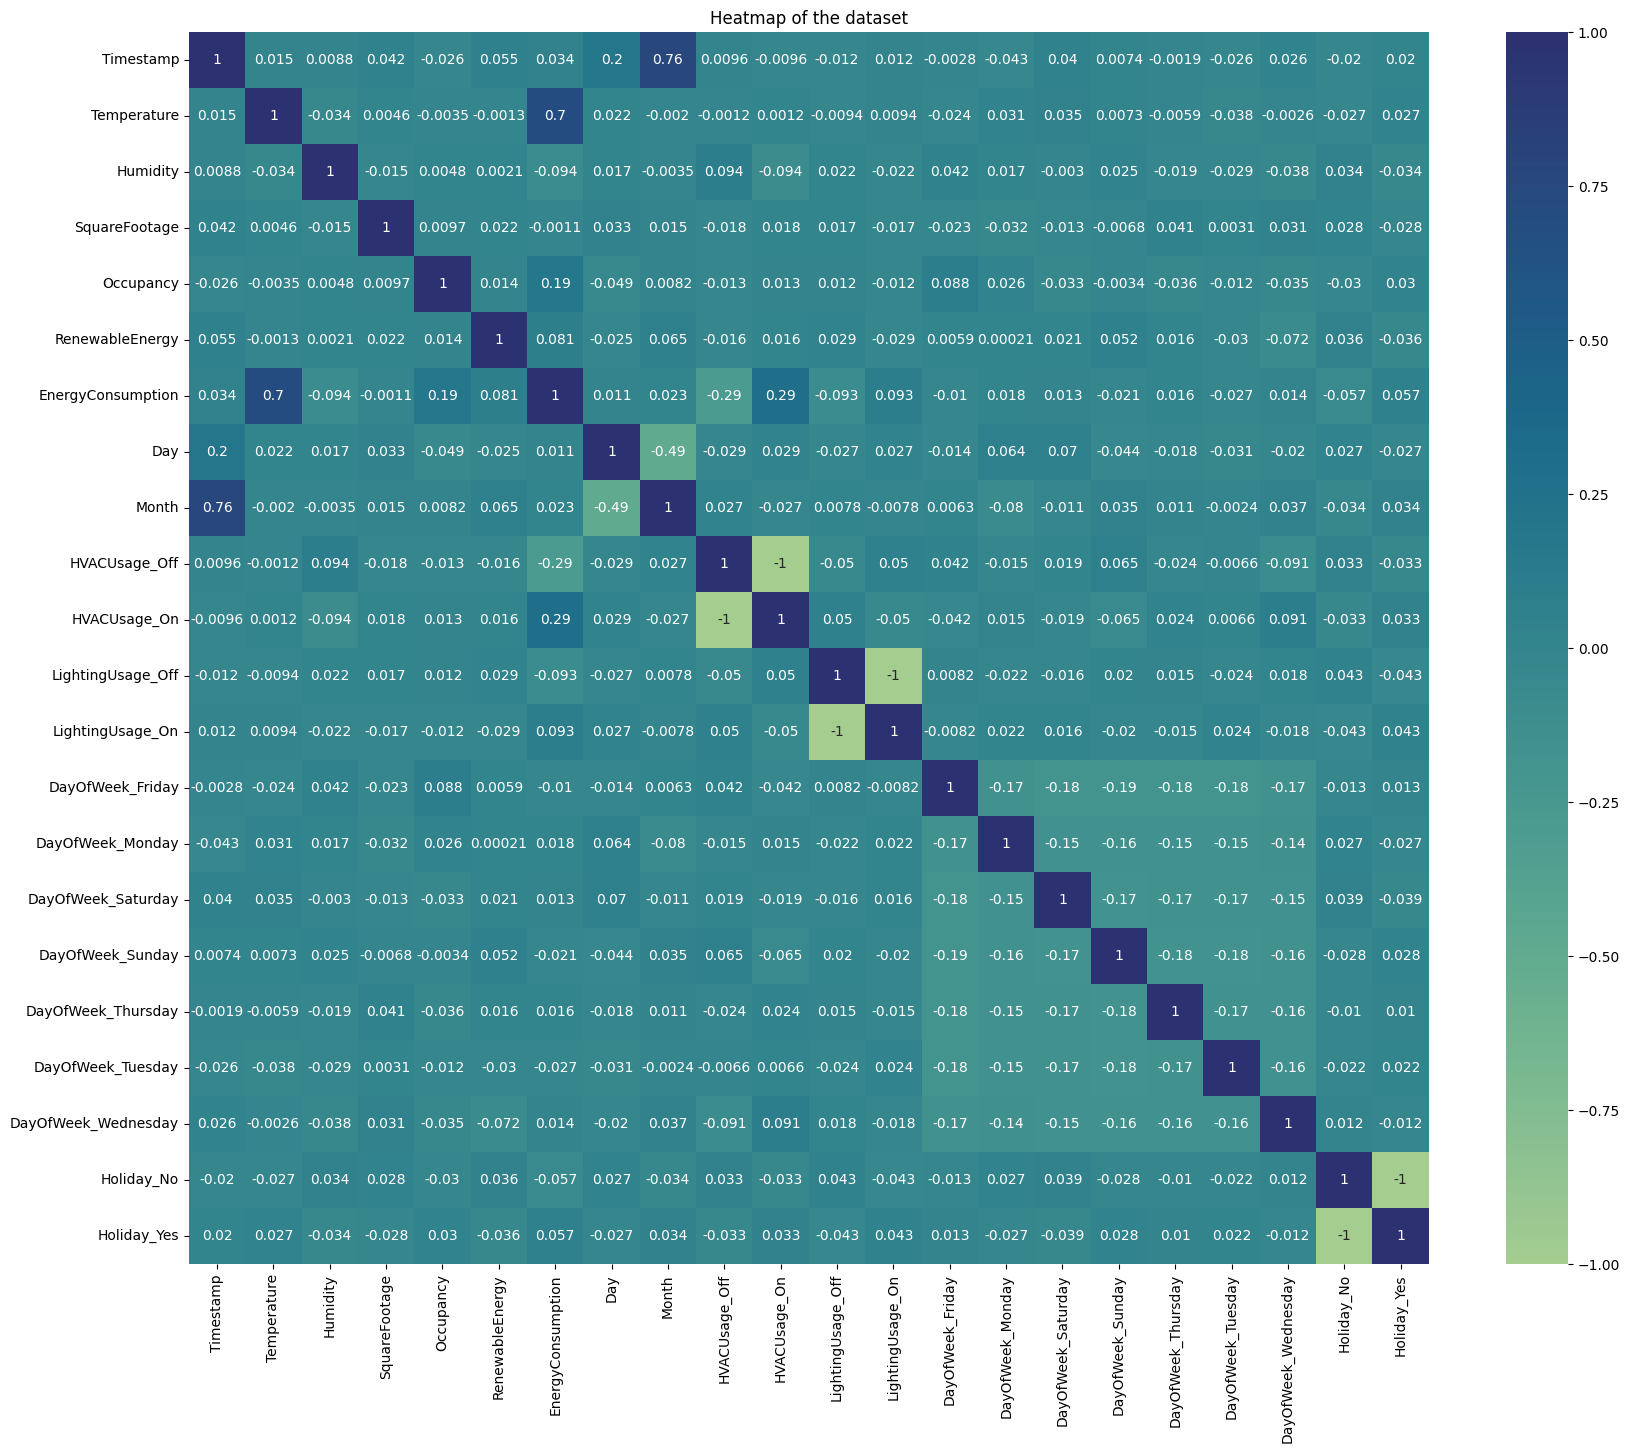

In [22]:
plt.figure(figsize=(20, 16))
sns.heatmap(data.corr(), annot=True, cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

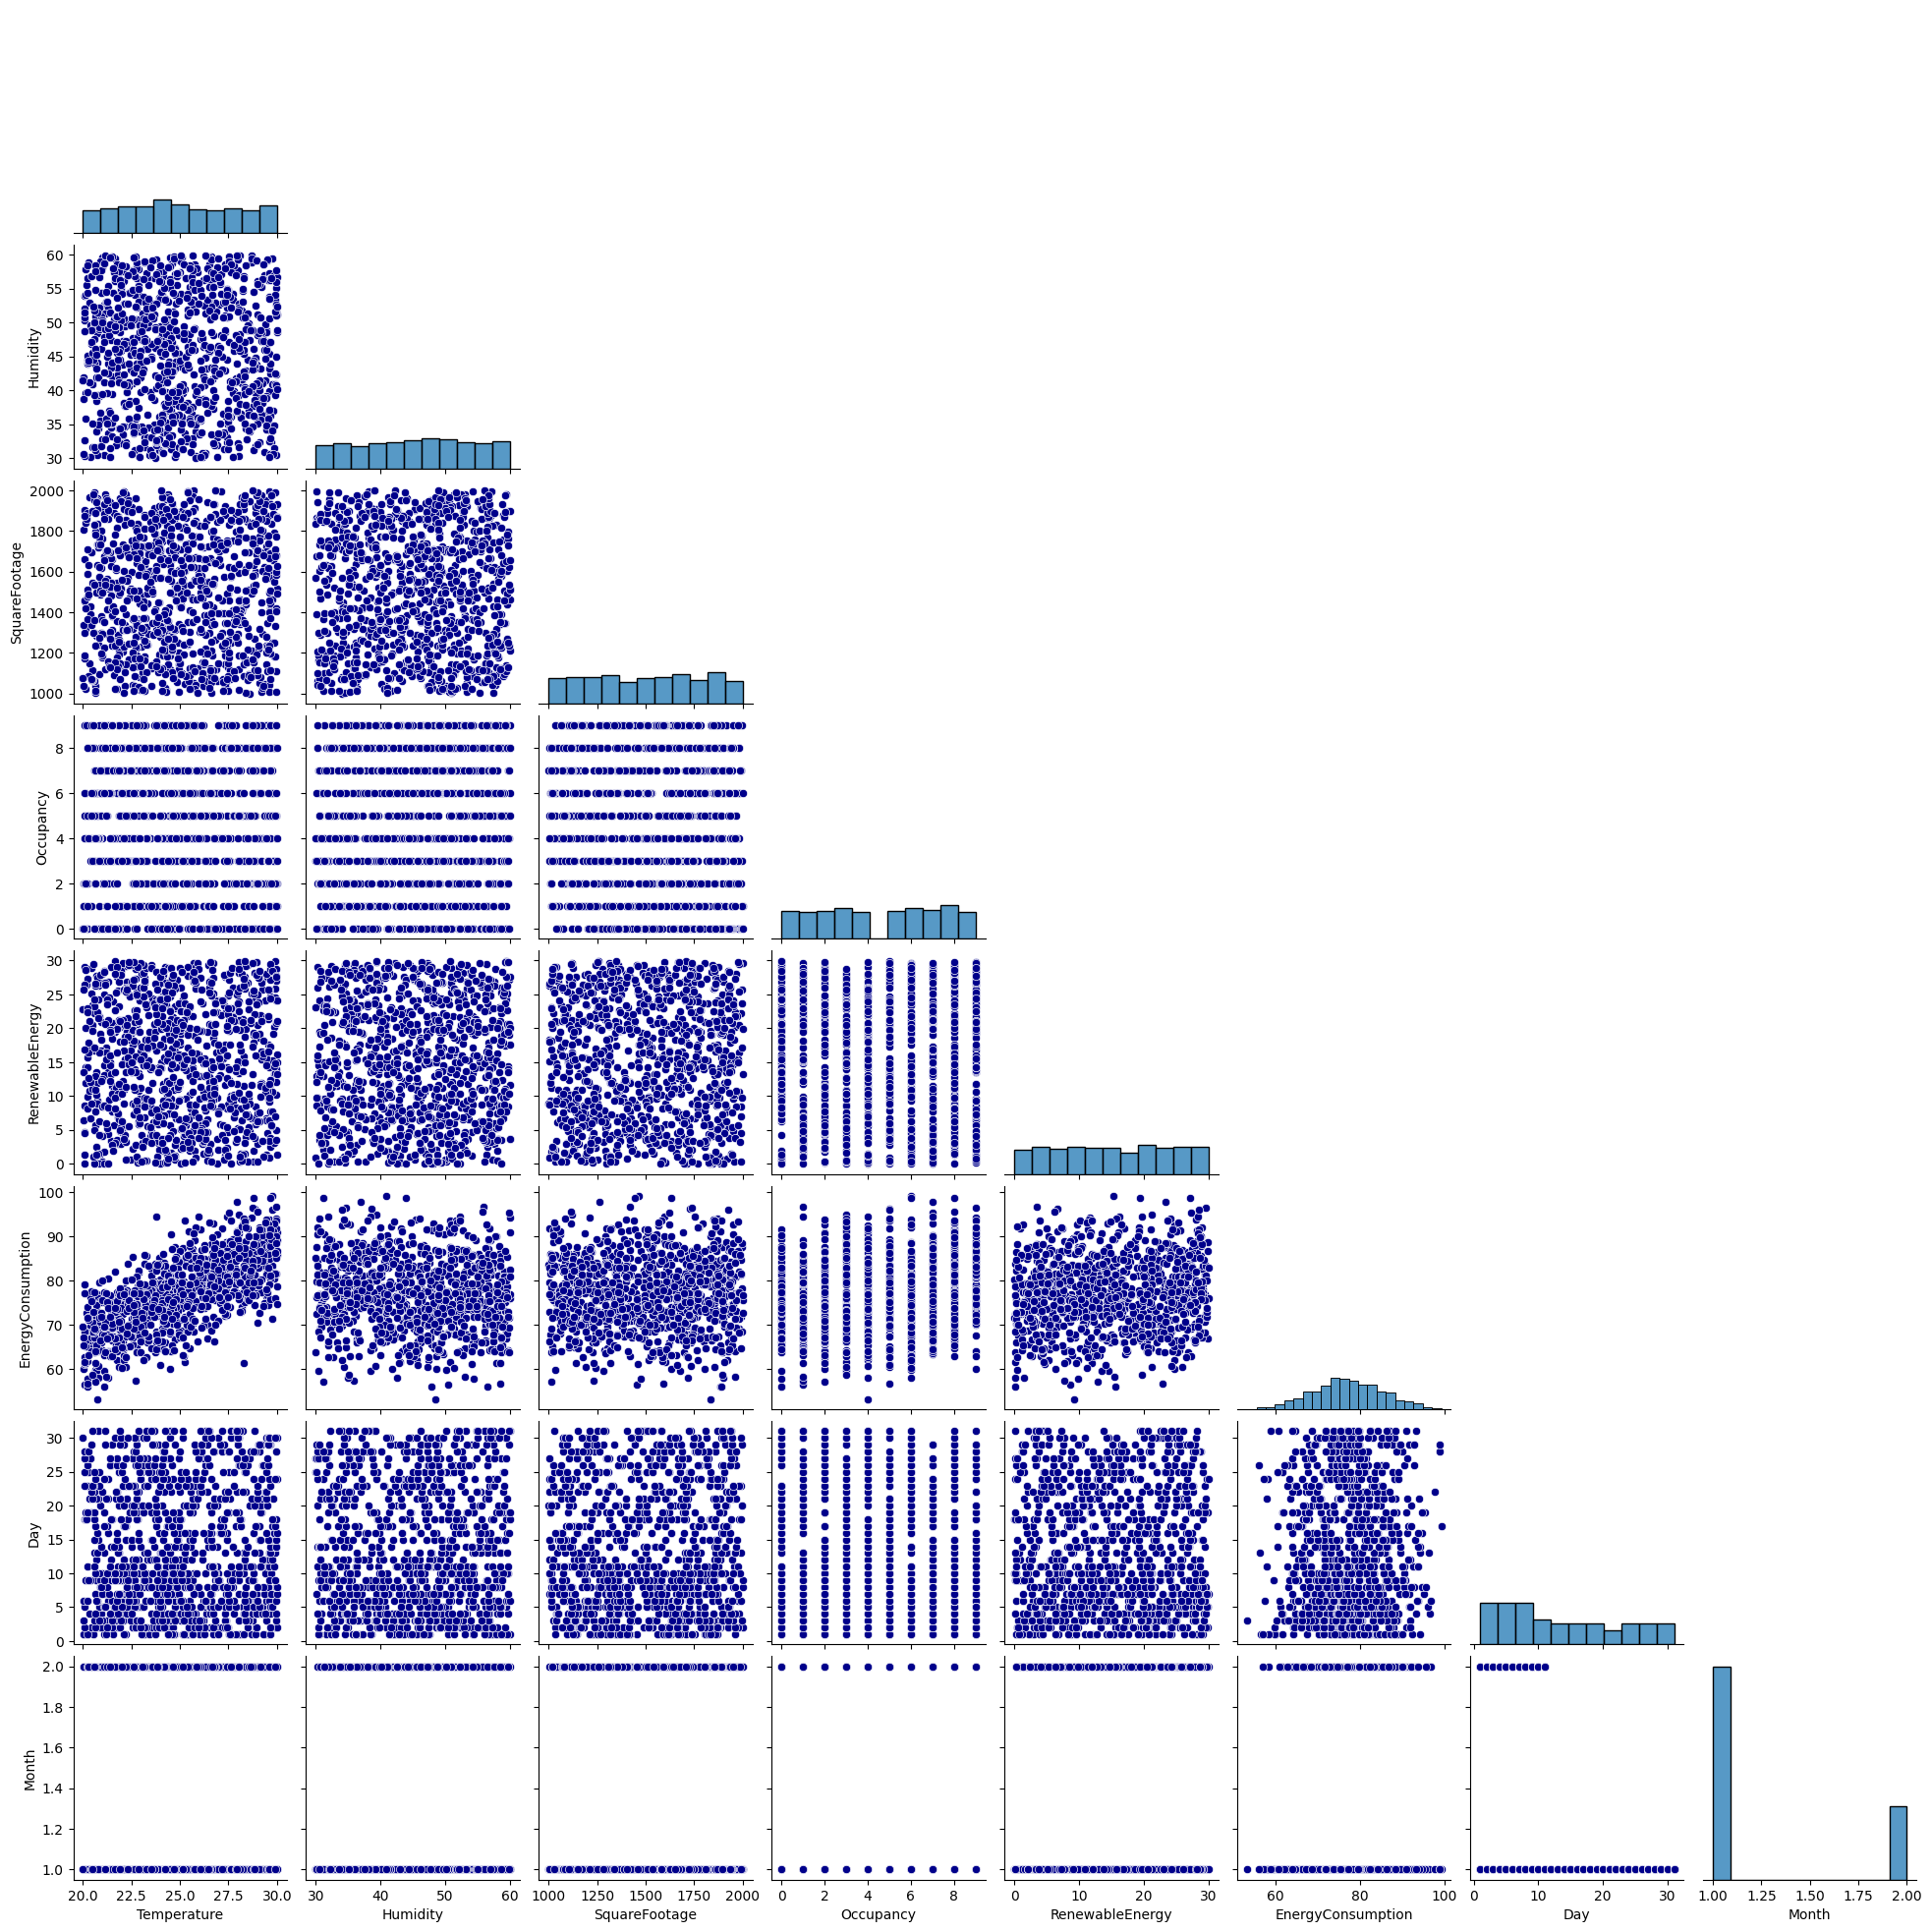

In [27]:
g = sns.pairplot(data[['Timestamp', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption', 'Day', 'Month']], corner = True, plot_kws = {'color':'darkblue'})
g.fig.show()

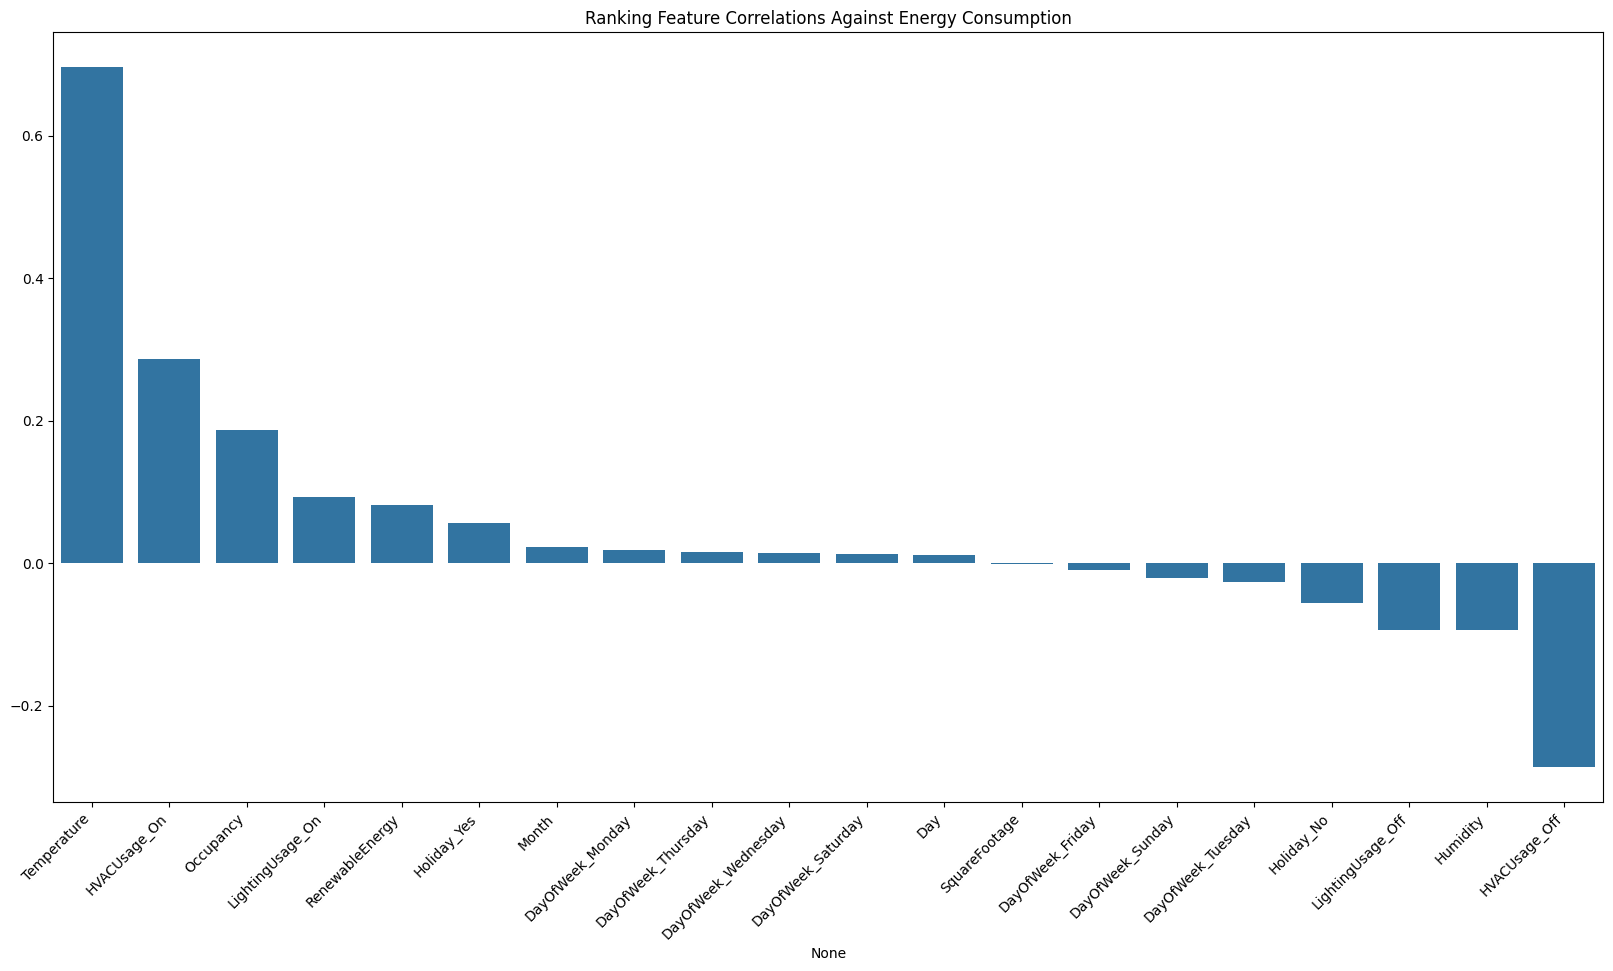

In [77]:
correlation_matrix = data.corr()

features = correlation_matrix['EnergyConsumption'].sort_values(ascending=False)[1:]
plt.figure(figsize=(20,10))
plt.title('Ranking Feature Correlations Against Energy Consumption')
sns.barplot(x=features.index,y=features.values)
plt.xticks(rotation=45, ha='right')
plt.show()

In [34]:
data.groupby('Month')['EnergyConsumption'].describe()

,count,mean,std,min,25%,50%,75%,max
Month,,,,,,,,
1,744.0,76.945109,8.190437,53.263278,71.420983,77.030949,82.498252,99.201120
2,256.0,77.377782,8.015110,56.849829,71.574651,76.716576,83.387363,96.827015


In [44]:
data = data.drop(['Timestamp'], axis = 1)

In [45]:
X = data.drop('EnergyConsumption', axis = 1)
y = data['EnergyConsumption']

In [46]:
SEED = 42

X_train, X_test, y_train, y_test = tts(X,
                                       y,
                                       test_size = 0.3,
                                       random_state = SEED)

In [66]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [67]:
lr.score(X_test, y_test)

0.6151791342530779

In [68]:
y_pred = lr.predict(X_test)

print(mean_squared_error(y_test, y_pred))

26.07838038796617


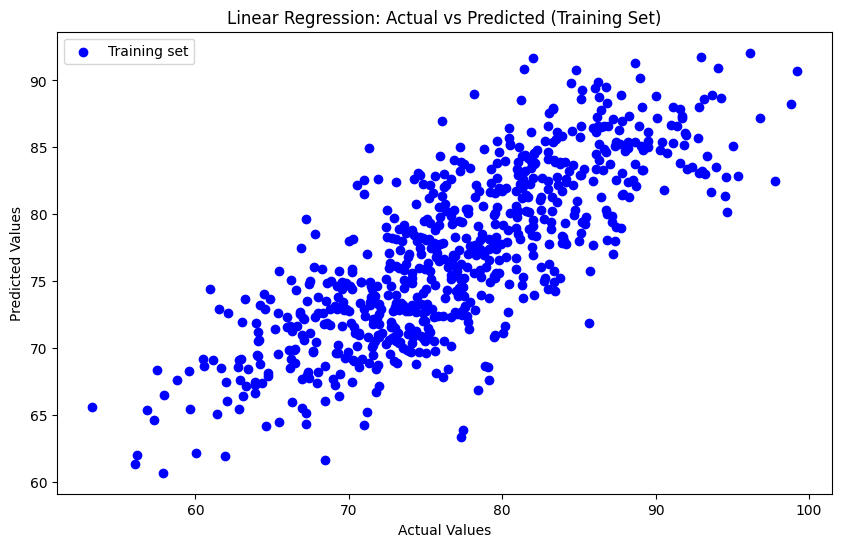

In [73]:
y_train_pred = lr.predict(X_train)

plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, c='blue', label='Training set')
plt.title('Linear Regression: Actual vs Predicted (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [47]:
reg1 = RandomForestRegressor(random_state = SEED, n_jobs = -1)
reg2 = ExtraTreesRegressor(bootstrap = True, n_jobs = -1, random_state = SEED)
reg3 = XGBRegressor(random_state = SEED, n_jobs = -1)
reg4 = LGBMRegressor(random_state = SEED, n_jobs = -1)
reg5 = CatBoostRegressor(random_state = SEED, verbose = 0)

MODELS = [reg1, reg2, reg3, reg4, reg5]

In [48]:
mae_train = {}
mae_test = {}

for model in tqdm(MODELS):
    name = type(model).__name__
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train[name] = mean_absolute_error(y_train, y_pred_train)
    mae_test[name] = mean_absolute_error(y_test, y_pred_test)
    print(f'* {name} finished.')

  0%|          | 0/5 [00:00<?, ?it/s]

* RandomForestRegressor finished.
* ExtraTreesRegressor finished.
* XGBRegressor finished.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 20
[LightGBM] [Info] Start training from score 77.013778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

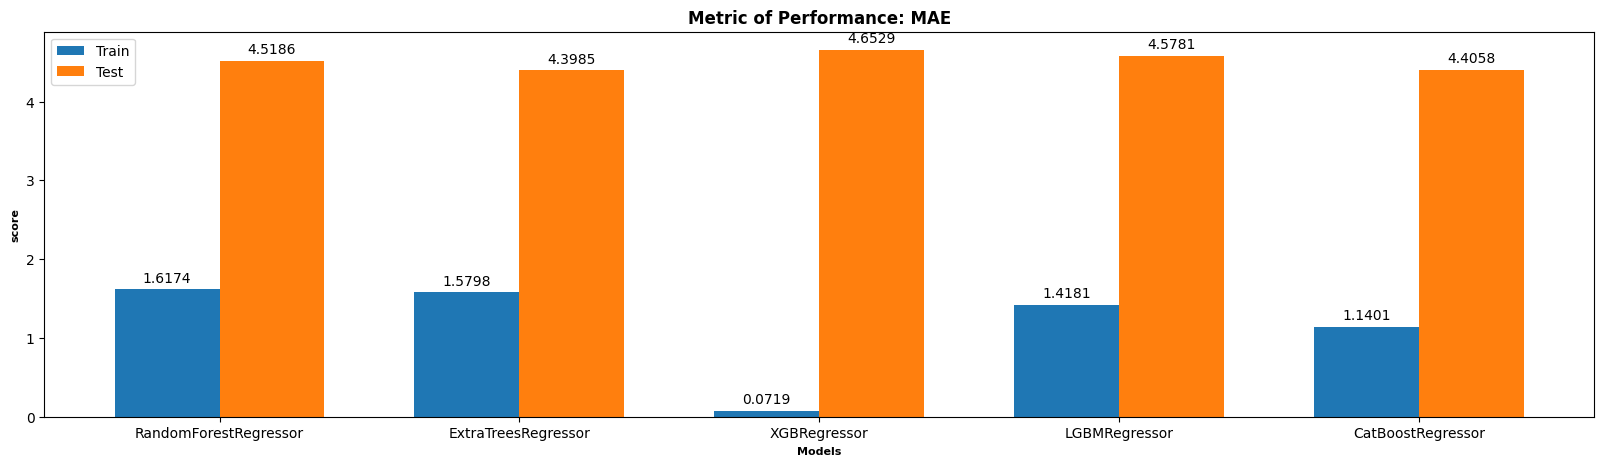

In [49]:
metric_train = pd.DataFrame.from_dict(mae_train, orient = 'index')
metric_train = metric_train.rename(columns = {0:'Train'})

metric_test = pd.DataFrame.from_dict(mae_test, orient = 'index')
metric_test = metric_test.rename(columns = {0:'Test'})

fig,ax = plt.subplots(figsize = (20,5))

labels = metric_train.index.to_list()
values_train = metric_train.iloc[:,0].to_list()
values_test = metric_test.iloc[:,0].to_list()
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x = x - width/2, height = values_train, width = width, label = 'Train')
rects2 = ax.bar(x = x + width/2, height = values_test, width = width, label = 'Test')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = f'{height:.4f}',
                    xy = (rect.get_x() + rect.get_width()/2, height),
                    xytext = (0,3),
                    textcoords = "offset points",
                    ha = "center",
                    va = "bottom")

autolabel(rects1)
autolabel(rects2)
ax.legend()
ax.set_title("Metric of Performance: MAE", fontsize = 12, fontweight = "bold", color = "black")
ax.set_ylabel("score", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xlabel("Models", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.show()

In [50]:
metric_train

,Train
RandomForestRegressor,1.617372
ExtraTreesRegressor,1.579794
XGBRegressor,0.071942
LGBMRegressor,1.418142
CatBoostRegressor,1.140101


In [51]:
metric_test

,Test
RandomForestRegressor,4.518592
ExtraTreesRegressor,4.398477
XGBRegressor,4.652889
LGBMRegressor,4.578110
CatBoostRegressor,4.405795


In [62]:
y_pred_xgb = reg3.predict(X_test)

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the metrics
print(f'Mean Absolute Error (MAE) for XGBoost: {mae_xgb}')
print(f'Mean Squared Error (MSE) for XGBoost: {mse_xgb}')
print(f'R-squared (R2) for XGBoost: {r2_xgb}')

Mean Absolute Error (MAE) for XGBoost: 4.652889430659862
Mean Squared Error (MSE) for XGBoost: 33.43654959386097
R-squared (R2) for XGBoost: 0.506599651861932


In [64]:
y_pred_catboost = reg5.predict(X_test)

# Calculate evaluation metrics
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

# Print the metrics
print(f'Mean Absolute Error (MAE) for CatBoost: {mae_catboost}')
print(f'Mean Squared Error (MSE) for CatBoost: {mse_catboost}')
print(f'R-squared (R2) for CatBoost: {r2_catboost}')



Mean Absolute Error (MAE) for CatBoost: 4.405794834905179
Mean Squared Error (MSE) for CatBoost: 29.39571477689369
R-squared (R2) for CatBoost: 0.5662274941386405


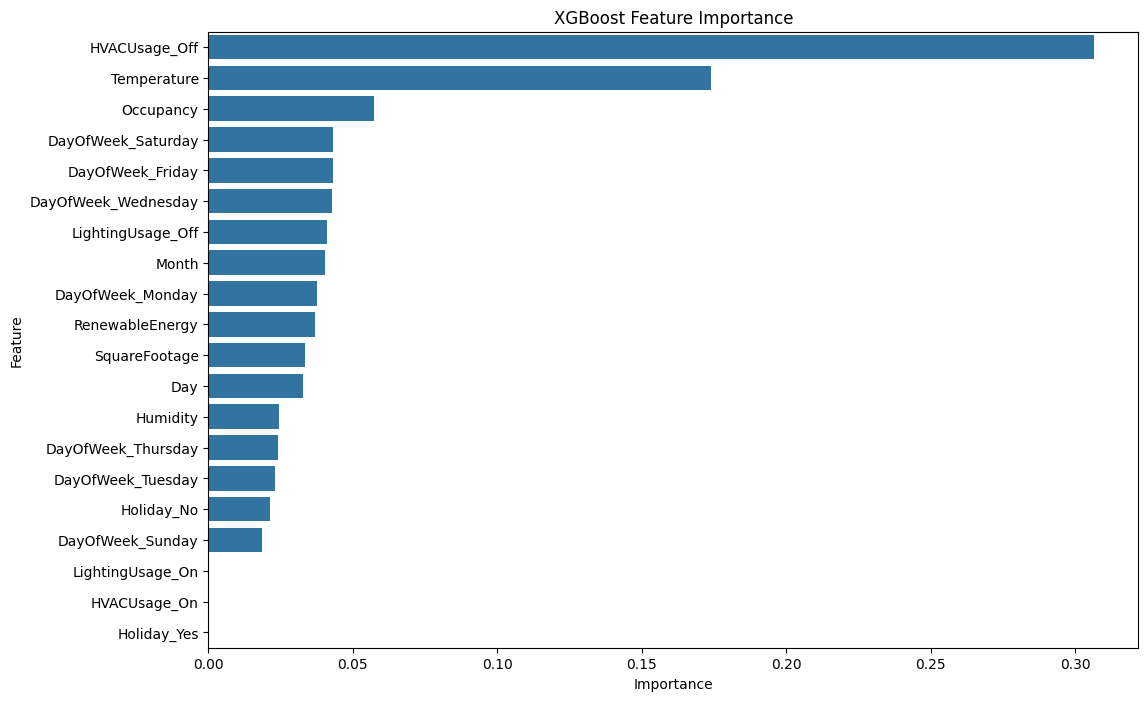

In [71]:
feature_importance_xgb = reg3.feature_importances_
feature_names = data.drop('EnergyConsumption', axis=1).columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_xgb})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb)
plt.title('XGBoost Feature Importance')
plt.show()


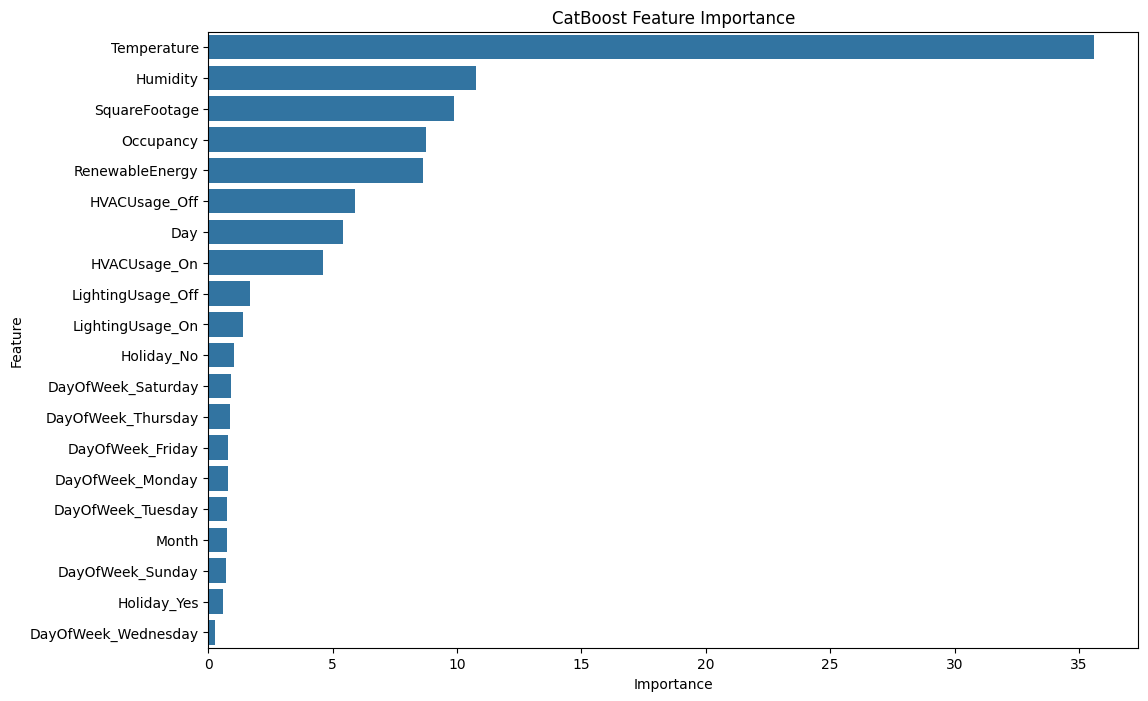

In [69]:

feature_importance_catboost = reg5.get_feature_importance()
feature_importance_df_catboost = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_catboost})
feature_importance_df_catboost = feature_importance_df_catboost.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_catboost)
plt.title('CatBoost Feature Importance')
plt.show()


In [59]:
e3 = shap.TreeExplainer(reg3)
shap_values3 = e3.shap_values(X_test)
shap_interaction_values3 = shap.TreeExplainer(reg3).shap_interaction_values(
    X_test
)

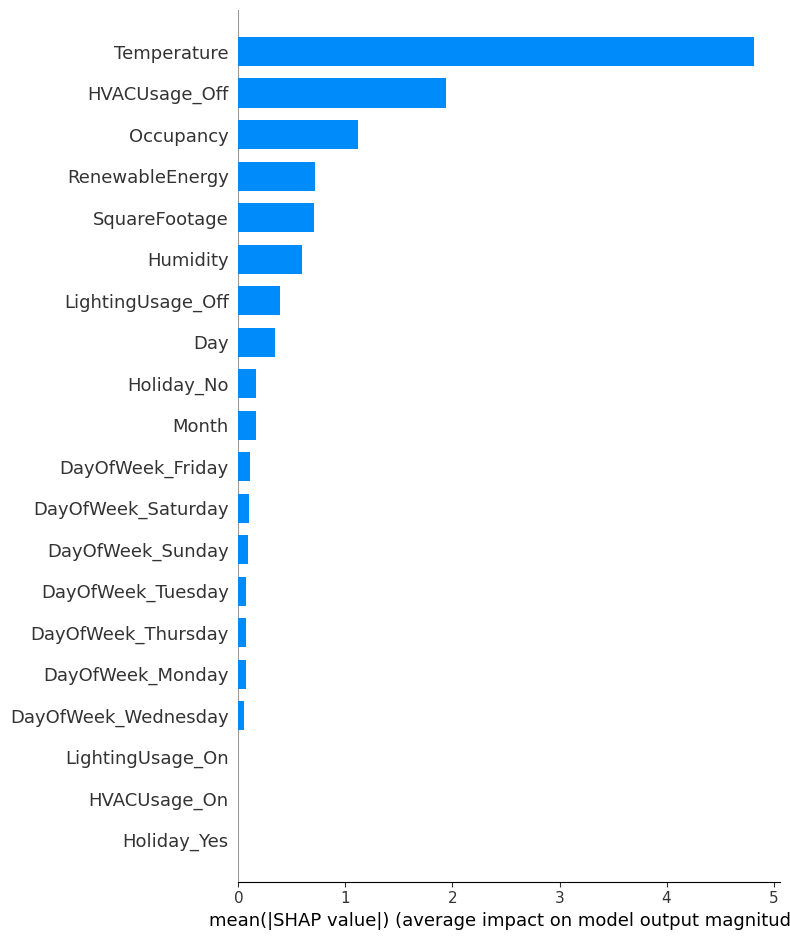

In [60]:
shap.summary_plot(shap_values3, X_test, plot_type="bar")

Let's do some hyperparameter tuning to see if we can get better performance out of the more complex models

In [81]:
xgb_model = XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new XGBoost model with the best hyperparameters
best_xgb_model = XGBRegressor(**best_params)

# Train the model on the entire training set
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb_tuned = best_xgb_model.predict(X_test)

# Evaluate the performance with the tuned model
mse_xgb_tuned = mean_squared_error(y_test, y_pred_xgb_tuned)

# Print the best hyperparameters and the tuned model's MSE
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error (MSE) for XGBoost (Tuned): {mse_xgb_tuned}')

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Mean Squared Error (MSE) for XGBoost (Tuned): 29.738242228815192


Still not better than the base model. Let's check feature importance to see if there's any change there

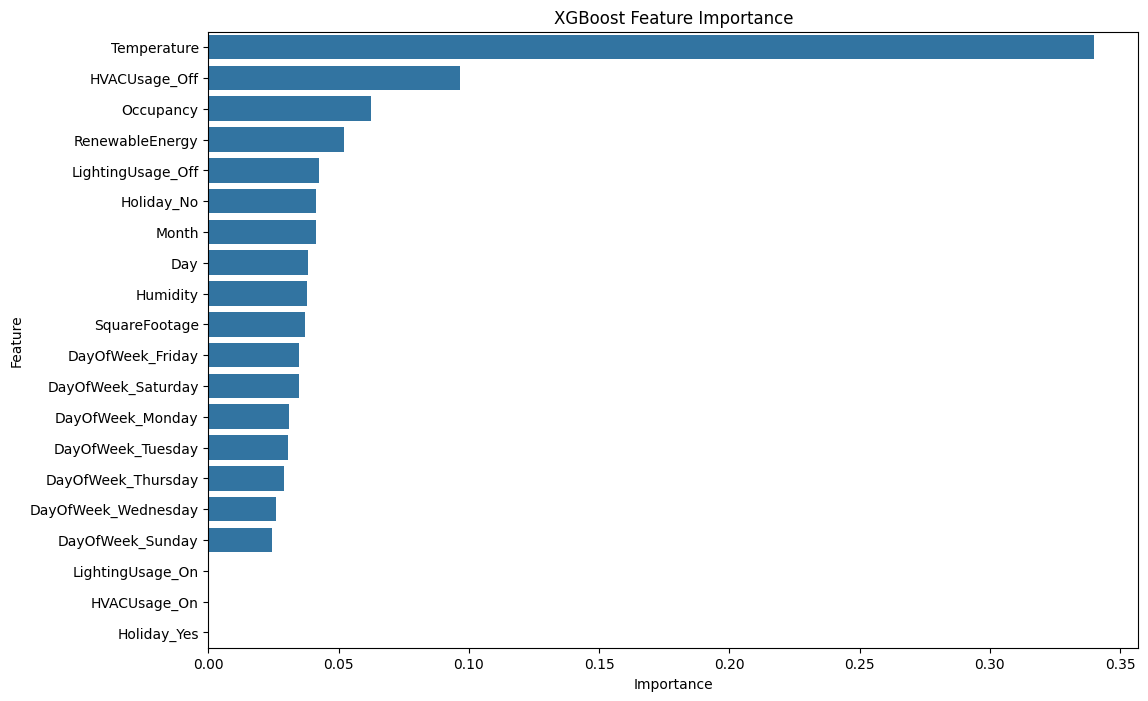

In [82]:
feature_importance_xgb = best_xgb_model.feature_importances_
feature_names = data.drop('EnergyConsumption', axis=1).columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_xgb})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb)
plt.title('XGBoost Feature Importance')
plt.show()

This has at least made the feature importance more coherent with the CatBoost model and the shap importances.

Let's try an ensemble method

In [89]:
from sklearn.ensemble import StackingRegressor

# Define the base models
base_models = [
    ('linear_regression', LinearRegression()),
    ('random_forest', RandomForestRegressor()),
    ('extra_trees', ExtraTreesRegressor()),
    ('lgbm', LGBMRegressor(silent=True)),
    ('xgboost', XGBRegressor()),
    ('catboost', CatBoostRegressor(silent=True)),  # Set silent=True to suppress CatBoost's output
]

# Define the meta-model
meta_model = LinearRegression()

# Initialize the StackingRegressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the StackingRegressor on the training set
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate the performance of the stacked model
mse_stacking = mean_squared_error(y_test, y_pred_stacking)




[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 20
[LightGBM] [Info] Start training from score 77.013778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [92]:
print(f'Mean Squared Error (MSE) for Stacking: {mse_stacking}')
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
print(f'Mean Absolute Error (MAE) for Stacking: {mae_stacking}')
r2_stacking = r2_score(y_test, y_pred_stacking)
print(f'R-squared (R2) for Stacking: {r2_stacking}')

Mean Squared Error (MSE) for Stacking: 26.500924481145088
Mean Absolute Error (MAE) for Stacking: 4.147717235720071
R-squared (R2) for Stacking: 0.6089439393776941
